# Phe vs Roche vs Warwick Model Comparison

In this notebook we use the `epimodels` module to investigate how non-pharmaceutical interventions impact the outcome of the epidemic. We use two models: the _PHE model_ by niversity of Cambridge, the _Roche model_ by F. Hoffmann-La Roche Ltd and the _Warwick Household model_ by University of Warwick, and run a forward simulation simulation both with and without NPIs, after they have been fitted to serology data.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**;
 - PHE regions of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The PHE model is built by Public Health England in collaboration with University of Cambridge. The Roche model is built by F. Hoffmann-La Roche Ltd. The Warwick model is built by University of Warwick.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
import scipy.stats
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(27)

## Model Setup
### Define setup matrices for the PHE, Roche and Warwick Household Model + NPIs

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))

### Variable
matrices_region_var = []

house_matrices_region_var = []
school_matrices_region_var = []
work_matrices_region_var = []
other_matrices_region_var = []

# Initial state of the system
for w in weeks:
    weeks_matrices_region_var = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix_var = pd.read_csv(path, header=None, dtype=np.float64)
        regional_var = em.RegionMatrix(r, age_groups, region_data_matrix_var)
        weeks_matrices_region_var.append(regional_var)

    matrices_region_var.append(weeks_matrices_region_var)

contacts_var = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_var = [contacts_var]

for w in weeks:
    house_weeks_matrices_region_var = []
    school_weeks_matrices_region_var = []
    work_weeks_matrices_region_var = []
    other_weeks_matrices_region_var = []

    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/house_{}_W{}.csv'.format(r, w))
        house_region_data_matrix_var = pd.read_csv(path, header=None, dtype=np.float64)
        house_regional_var = em.RegionMatrix(r, age_groups, house_region_data_matrix_var)
        house_weeks_matrices_region_var.append(house_regional_var)

        path2 = os.path.join('../../data/final_contact_matrices/school_{}_W{}.csv'.format(r, w))
        school_region_data_matrix_var = pd.read_csv(path2, header=None, dtype=np.float64)
        school_regional_var = em.RegionMatrix(r, age_groups, school_region_data_matrix_var)
        school_weeks_matrices_region_var.append(school_regional_var)

        path3 = os.path.join('../../data/final_contact_matrices/work_{}_W{}.csv'.format(r, w))
        work_region_data_matrix_var = pd.read_csv(path3, header=None, dtype=np.float64)
        work_regional_var = em.RegionMatrix(r, age_groups, work_region_data_matrix_var)
        work_weeks_matrices_region_var.append(work_regional_var)

        path4 = os.path.join('../../data/final_contact_matrices/other_{}_W{}.csv'.format(r, w))
        other_region_data_matrix_var = pd.read_csv(path4, header=None, dtype=np.float64)
        other_regional_var = em.RegionMatrix(r, age_groups, other_region_data_matrix_var)
        other_weeks_matrices_region_var.append(other_regional_var)

    house_matrices_region_var.append(house_weeks_matrices_region_var)
    school_matrices_region_var.append(school_weeks_matrices_region_var)
    work_matrices_region_var.append(work_weeks_matrices_region_var)
    other_matrices_region_var.append(other_weeks_matrices_region_var)

contacts_var = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
house_matrices_contact_var = [contacts_var]
school_matrices_contact_var = [contacts_var]
work_matrices_contact_var = [contacts_var]
other_matrices_contact_var = [contacts_var]

# Matrices contact
time_changes_contact_var = [1]
time_changes_region_var = np.arange(1, total_days+1, 7).tolist()

### Fixed
matrices_region_fix = []

house_matrices_region_fix = []
school_matrices_region_fix = []
work_matrices_region_fix = []
other_matrices_region_fix = []

# Initial state of the system
weeks_matrices_region_fix = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix_fix = pd.read_csv(path, header=None, dtype=np.float64)
    regional_fix = em.RegionMatrix(r, age_groups, region_data_matrix_fix)
    weeks_matrices_region_fix.append(regional_fix)

matrices_region_fix.append(weeks_matrices_region_fix)

contacts_fix = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact_fix = [contacts_fix]

house_weeks_matrices_region_fix = []
school_weeks_matrices_region_fix = []
work_weeks_matrices_region_fix = []
other_weeks_matrices_region_fix = []

for r in regions:
    path = os.path.join('../../data/final_contact_matrices/house_BASE.csv')
    house_region_data_matrix_fix = pd.read_csv(path, header=None, dtype=np.float64)
    house_regional_fix = em.RegionMatrix(r, age_groups, house_region_data_matrix_fix)
    house_weeks_matrices_region_fix.append(house_regional_fix)

    path2 = os.path.join('../../data/final_contact_matrices/school_BASE.csv')
    school_region_data_matrix_fix = pd.read_csv(path2, header=None, dtype=np.float64)
    school_regional_fix = em.RegionMatrix(r, age_groups, school_region_data_matrix_fix)
    school_weeks_matrices_region_fix.append(school_regional_fix)

    path3 = os.path.join('../../data/final_contact_matrices/work_BASE.csv')
    work_region_data_matrix_fix = pd.read_csv(path3, header=None, dtype=np.float64)
    work_regional_fix = em.RegionMatrix(r, age_groups, work_region_data_matrix_fix)
    work_weeks_matrices_region_fix.append(work_regional_fix)

    path4 = os.path.join('../../data/final_contact_matrices/other_BASE.csv')
    other_region_data_matrix_fix = pd.read_csv(path4, header=None, dtype=np.float64)
    other_regional_fix = em.RegionMatrix(r, age_groups, other_region_data_matrix_fix)
    other_weeks_matrices_region_fix.append(other_regional_fix)

house_matrices_region_fix.append(house_weeks_matrices_region_fix)
school_matrices_region_fix.append(school_weeks_matrices_region_fix)
work_matrices_region_fix.append(work_weeks_matrices_region_fix)
other_matrices_region_fix.append(other_weeks_matrices_region_fix)

contacts_fix = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
house_matrices_contact_fix = [contacts_fix]
school_matrices_contact_fix = [contacts_fix]
work_matrices_contact_fix = [contacts_fix]
other_matrices_contact_fix = [contacts_fix]

# Matrices contact
time_changes_contact_fix = [1]
time_changes_region_fix = [1]

### With NPIs data
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
path = os.path.join('../../data/npi_data/')
general_npi_yes = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag_yes = np.loadtxt(os.path.join(path, 'times_flags.csv'), dtype=int, delimiter=',').tolist()

reg_levels_npi_yes = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi_yes = np.loadtxt(os.path.join(path, 'times_npis.csv'), dtype=int, delimiter=',').tolist()

### No NPIs
general_npi_no = [[False, False, False, False, False, False, False, False, False]]
time_changes_flag_no = [1]

reg_levels_npi_no = [[[0, 0, 0, 0, 0, 0, 0, 0, 0]]]
time_changes_npi_no = [1]


### Set the parameters and initial conditions of the model and bundle everything together

### PHE with variable contacts

In [3]:
# Instantiate model
phe_model_var = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_var.set_regions(regions)
phe_model_var.set_age_groups(age_groups)
phe_model_var.read_contact_data(matrices_contact_var, time_changes_contact_var)
phe_model_var.read_regional_data(matrices_region_var, time_changes_region_var)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 50
infectives1 = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()


# List of times at which we wish to evaluate the states of the compartments of the phe_model_var
times = np.arange(1, total_days+1, 1).tolist()

In [4]:
### Variable Model
# Set regional and time dependent parameters
phe_model_var_regional_parameters = em.PheRegParameters(
    model=phe_model_var,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_var_ICs = em.PheICs(
    model=phe_model_var,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_var_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_var,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_var_simulation_parameters = em.PheSimParameters(
    model=phe_model_var,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_var_parameters = em.PheParametersController(
    model=phe_model_var,
    regional_parameters=phe_model_var_regional_parameters,
    ICs=phe_model_var_ICs,
    disease_parameters=phe_model_var_disease_parameters,
    simulation_parameters=phe_model_var_simulation_parameters
)

### PHE with fixed contacts

In [5]:
# Instantiate phe_model_var
phe_model_fix = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model_fix.set_regions(regions)
phe_model_fix.set_age_groups(age_groups)
phe_model_fix.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
phe_model_fix.read_regional_data(matrices_region_fix, time_changes_region_fix)


In [6]:
### Fixed Model
# Set regional and time dependent parameters
phe_model_fix_regional_parameters = em.PheRegParameters(
    model=phe_model_fix,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_fix_ICs = em.PheICs(
    model=phe_model_fix,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_fix_disease_parameters = em.PheDiseaseParameters(
    model=phe_model_fix,
    dL=4,
    dI=4
)

# Set other simulation parameters
phe_model_fix_simulation_parameters = em.PheSimParameters(
    model=phe_model_fix,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_fix_parameters = em.PheParametersController(
    model=phe_model_fix,
    regional_parameters=phe_model_fix_regional_parameters,
    ICs=phe_model_fix_ICs,
    disease_parameters=phe_model_fix_disease_parameters,
    simulation_parameters=phe_model_fix_simulation_parameters
)

### Roche with NPIs

In [7]:
# Instantiate model
roche_model_var = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_var.set_regions(regions)
roche_model_var.set_age_groups(age_groups)
roche_model_var.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
roche_model_var.read_regional_data(matrices_region_fix, time_changes_region_fix)
roche_model_var.read_npis_data(max_levels_npi, targeted_npi, general_npi_yes, reg_levels_npi_yes, time_changes_npi_yes, time_changes_flag_yes)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 40
infectives = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

In [8]:
# Set ICs parameters
roche_model_var_ICs = em.RocheICs(
    model=roche_model_var,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=infectives,
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_var_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_var,
    k=6.8,
    kS=5,
    kQ=2.5,
    kR=8,
    kRI=10.5
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_var_proportion_parameters = em.RocheProportions(
    model=roche_model_var,
    Pa = 0.6,
    Pss = 0.15,
    Pd = pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values.tolist()
)

# Set transmission parameters
roche_model_var_transmission_parameters = em.RocheTransmission(
    model=roche_model_var,
    beta_min=0.228,
    beta_max=1.8,
    bss=3.11,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_var_simulation_parameters = em.RocheSimParameters(
    model=roche_model_var,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_var_parameters = em.RocheParametersController(
    model=roche_model_var,
    ICs=roche_model_var_ICs,
    compartment_times=roche_model_var_compartment_times,
    proportion_parameters=roche_model_var_proportion_parameters,
    transmission_parameters=roche_model_var_transmission_parameters,
    simulation_parameters=roche_model_var_simulation_parameters
)

### Roche without NPIs

In [9]:
# Instantiate model
roche_model_fix = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_fix.set_regions(regions)
roche_model_fix.set_age_groups(age_groups)
roche_model_fix.read_contact_data(matrices_contact_fix, time_changes_contact_fix)
roche_model_fix.read_regional_data(matrices_region_fix, time_changes_region_fix)
roche_model_fix.read_npis_data(max_levels_npi, targeted_npi, general_npi_no, reg_levels_npi_no, time_changes_npi_no, time_changes_flag_no)

In [10]:
# Set ICs parameters
roche_model_fix_ICs = em.RocheICs(
    model=roche_model_fix,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=infectives,
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_fix_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_fix,
    k=6.8,
    kS=5,
    kQ=2.5,
    kR=8,
    kRI=10.5
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_fix_proportion_parameters = em.RocheProportions(
    model=roche_model_fix,
    Pa = 0.6,
    Pss = 0.15,
    Pd = pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values.tolist()
)

# Set transmission parameters
roche_model_fix_transmission_parameters = em.RocheTransmission(
    model=roche_model_fix,
    beta_min=0.228,
    beta_max=1.8,
    bss=3.11,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_fix_simulation_parameters = em.RocheSimParameters(
    model=roche_model_fix,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_fix_parameters = em.RocheParametersController(
    model=roche_model_fix,
    ICs=roche_model_fix_ICs,
    compartment_times=roche_model_fix_compartment_times,
    proportion_parameters=roche_model_fix_proportion_parameters,
    transmission_parameters=roche_model_fix_transmission_parameters,
    simulation_parameters=roche_model_fix_simulation_parameters
)

### Warwick Household with NPIs

In [11]:
# Instantiate model
warwick_model_var = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model_var.set_regions(regions)
warwick_model_var.set_age_groups(age_groups)
warwick_model_var.read_contact_data(house_matrices_contact_var, school_matrices_contact_var, work_matrices_contact_var, other_matrices_contact_var, time_changes_contact_var)
warwick_model_var.read_regional_data(house_matrices_region_var, school_matrices_region_var, work_matrices_region_var, other_matrices_region_var, time_changes_region_var)

In [12]:
# Read extended age-group data for optimisation
extended_susceptibles = np.loadtxt('../../data/england_population/UK_PP.csv', delimiter=',').astype(int)
extended_infectives_prop = np.loadtxt('../../data/england_population/UK_Ages.csv', delimiter=',')

extended_house_cont_mat = np.loadtxt('../../data/england_population/UK_from_toH.csv', delimiter=',')
extended_school_cont_mat = np.loadtxt('../../data/england_population/UK_from_toS.csv', delimiter=',')
extended_work_cont_mat = np.loadtxt('../../data/england_population/UK_from_toW.csv', delimiter=',')
extended_other_cont_mat = np.loadtxt('../../data/england_population/UK_from_toO.csv', delimiter=',')

In [13]:
def update_age_groups(population, parameter_vector):
    """
    """
    new_vector = np.empty(8)

    ind_old = [
        np.array([0]),
        np.array([0]),
        np.array(range(1, 3)),
        np.array(range(3, 5)),
        np.array(range(5, 9)),
        np.array(range(9, 13)),
        np.array(range(13, 15)),
        np.array(range(15, 21))]

    for _ in range(8):
        new_vector[_] = np.average(
            np.array(parameter_vector)[ind_old[_][:, None]],
            weights=population[ind_old[_][:, None]])

    return new_vector

In [14]:
def stack_age_groups(population, parameter_vector, r):
        """
        """
        new_vector = np.empty(8)

        ind_old = [
            np.array([0]),
            np.array([0]),
            np.array(range(1, 3)),
            np.array(range(3, 5)),
            np.array(range(5, 9)),
            np.array(range(9, 13)),
            np.array(range(13, 15)),
            np.array(range(15, 21))]

        if np.asarray(population).ndim != 1:
            new_vector[0] = \
                parameter_vector[0] * population[r, 0] / (
                    population[r, 0] + population[r, 1])

            new_vector[1] = \
                parameter_vector[0] * population[r, 1] / (
                    population[r, 0] + population[r, 1])

        else:
            new_vector[0] = \
                parameter_vector[0] * population[0] / (
                    population[0] + population[1])

            new_vector[1] = \
                parameter_vector[0] * population[1] / (
                    population[0] + population[1])

        for _ in range(2, 8):
            new_vector[_] = np.sum(parameter_vector[ind_old[_][:, None]])

        return new_vector

In [15]:
pop = extended_susceptibles
N = np.sum(pop)

In [16]:
# Set regional and time dependent parameters
warwick_model_var_regional_parameters = em.WarwickRegParameters(
    model=warwick_model_var,
    region_index=1,
    H=0.8 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_var_ICs = em.WarwickICs(
    model=warwick_model_var,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[update_age_groups(pop, (20 * extended_infectives_prop).astype(int)).tolist()],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_var_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model_var,
    tau=0.4,
    d=0.4 * np.ones(len(age_groups))
)

# Set transmission parameters
warwick_model_var_transmission_parameters = em.WarwickTransmission(
    model=warwick_model_var,
    epsilon=0.2,
    gamma=1,
    sigma=0.5 * np.ones(len(age_groups))
)

# Set other simulation parameters
warwick_model_var_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model_var,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_var_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model_var,
)

# Set all parameters in the controller
warwick_model_var_parameters = em.WarwickParametersController(
    model=warwick_model_var,
    regional_parameters=warwick_model_var_regional_parameters,
    ICs=warwick_model_var_ICs,
    disease_parameters=warwick_model_var_disease_parameters,
    transmission_parameters=warwick_model_var_transmission_parameters,
    simulation_parameters=warwick_model_var_simulation_parameters,
    soc_dist_parameters=warwick_model_var_soc_dist_parameters
)

### Warwick Household without NPIs

In [17]:
# Instantiate model
warwick_model_fix = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model_fix.set_regions(regions)
warwick_model_fix.set_age_groups(age_groups)
warwick_model_fix.read_contact_data(house_matrices_contact_fix, school_matrices_contact_fix, work_matrices_contact_fix, other_matrices_contact_fix, time_changes_contact_fix)
warwick_model_fix.read_regional_data(house_matrices_region_fix, school_matrices_region_fix, work_matrices_region_fix, other_matrices_region_fix, time_changes_region_fix)

In [18]:
# Set regional and time dependent parameters
warwick_model_fix_regional_parameters = em.WarwickRegParameters(
    model=warwick_model_fix,
    region_index=1,
    H=0.8 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_fix_ICs = em.WarwickICs(
    model=warwick_model_fix,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[update_age_groups(pop, (20 * extended_infectives_prop).astype(int)).tolist()],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_fix_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model_fix,
    tau=0.4,
    d=0.4 * np.ones(len(age_groups))
)

# Set transmission parameters
warwick_model_fix_transmission_parameters = em.WarwickTransmission(
    model=warwick_model_fix,
    epsilon=0.2,
    gamma=1,
    sigma=0.5 * np.ones(len(age_groups))
)

# Set other simulation parameters
warwick_model_fix_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model_fix,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_fix_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model_fix,
)

# Set all parameters in the controller
warwick_model_fix_parameters = em.WarwickParametersController(
    model=warwick_model_fix,
    regional_parameters=warwick_model_fix_regional_parameters,
    ICs=warwick_model_fix_ICs,
    disease_parameters=warwick_model_fix_disease_parameters,
    transmission_parameters=warwick_model_fix_transmission_parameters,
    simulation_parameters=warwick_model_fix_simulation_parameters,
    soc_dist_parameters=warwick_model_fix_soc_dist_parameters
)

## Death and Serology data
### Read Death and Serology data

In [19]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [20]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [21]:
# Add folder path to data file
path = os.path.join('../../data/')

RF_df = pd.read_csv(
    os.path.join(path, 'risks_death/Risks_United Kingdom.csv'),
    dtype=np.float64)

param_df = pd.read_csv(
        os.path.join(path, 'global_parameters/parameters.csv'),
        dtype=np.float64)

pDtoH = update_age_groups(extended_susceptibles, RF_df['hospitalisation_risk'].tolist())
pHtoDeath = update_age_groups(extended_susceptibles, RF_df['death_risk'].tolist())

th_mean = param_df['hosp_lag'].tolist()[0]+0.00001
th_var = 12.1**2
theta = th_var / th_mean
k = th_mean / theta
dDtoH = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

td_mean = param_df['death_lag'].tolist()[0]
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
dHtoDeath = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

In [22]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = pd.read_csv('../../data/fatality_ratio_data/IFR.csv', usecols=['ifr'], dtype=np.float64)['ifr'].values.tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_1316/1803175120.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))


## Model Fitting
### PHE (with variable contacts)

In [23]:
# Initialise inference for the model
phe_inference_var = em.inference.PheSEIRInfer(phe_model_var)

# Add model, death and tests data to the inference structure
phe_inference_var.read_model_data(susceptibles, infectives1)
phe_inference_var.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
phe_inference_var.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
phe_var_samples = phe_inference_var.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time    
0     12     -8396.053 -8396.053   0:01.3
1     24     -8232.912 -8232.912   0:02.5
2     36     -7961.669 -7961.669   0:03.7
3     48     -7638.474 -7638.474   0:05.0


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:343: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+d+1]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:344: RuntimeWarning: invalid value encountered in log
  loc=np.log(x[r*LEN+d]),


20    252    -3627.668 -3627.668   0:25.3


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


40    492    -3459.811 -3591.291   0:51.8
60    732    -3433.674 -3461.6     1:18.0
80    972    -3298.276 -3368.231   1:44.2
100   1212   -3270.746 -3280.665   2:10.6
120   1452   -3252.338 -3253.551   2:36.3
140   1692   -3243.274 -3243.911   3:01.2
160   1932   -3236.883 -3236.883   3:26.0
180   2172   -3223.068 -3223.068   3:50.5
200   2412   -3212.865 -3213.107   4:14.2
220   2652   -3209.209 -3209.209   4:37.3
240   2892   -3208.605 -3208.678   5:00.0
260   3132   -3208.45  -3208.472   5:22.6
280   3372   -3208.421 -3208.434   5:45.3
300   3612   -3208.415 -3208.419   6:08.2
320   3852   -3208.4   -3208.406   6:31.5
321   3852   -3208.4   -3208.406   6:31.5
Halting: No significant change for 100 iterations.
[3.30175021 0.55069519 0.31799651 0.34971776 0.44882217 0.5172677
 0.51618791 0.49672847 0.48455829 0.47709456 0.46946732 0.46922122
 0.46834107 0.46778307 0.1603719 ] -3208.3996225992582
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC

### Quality check of the inference procedure

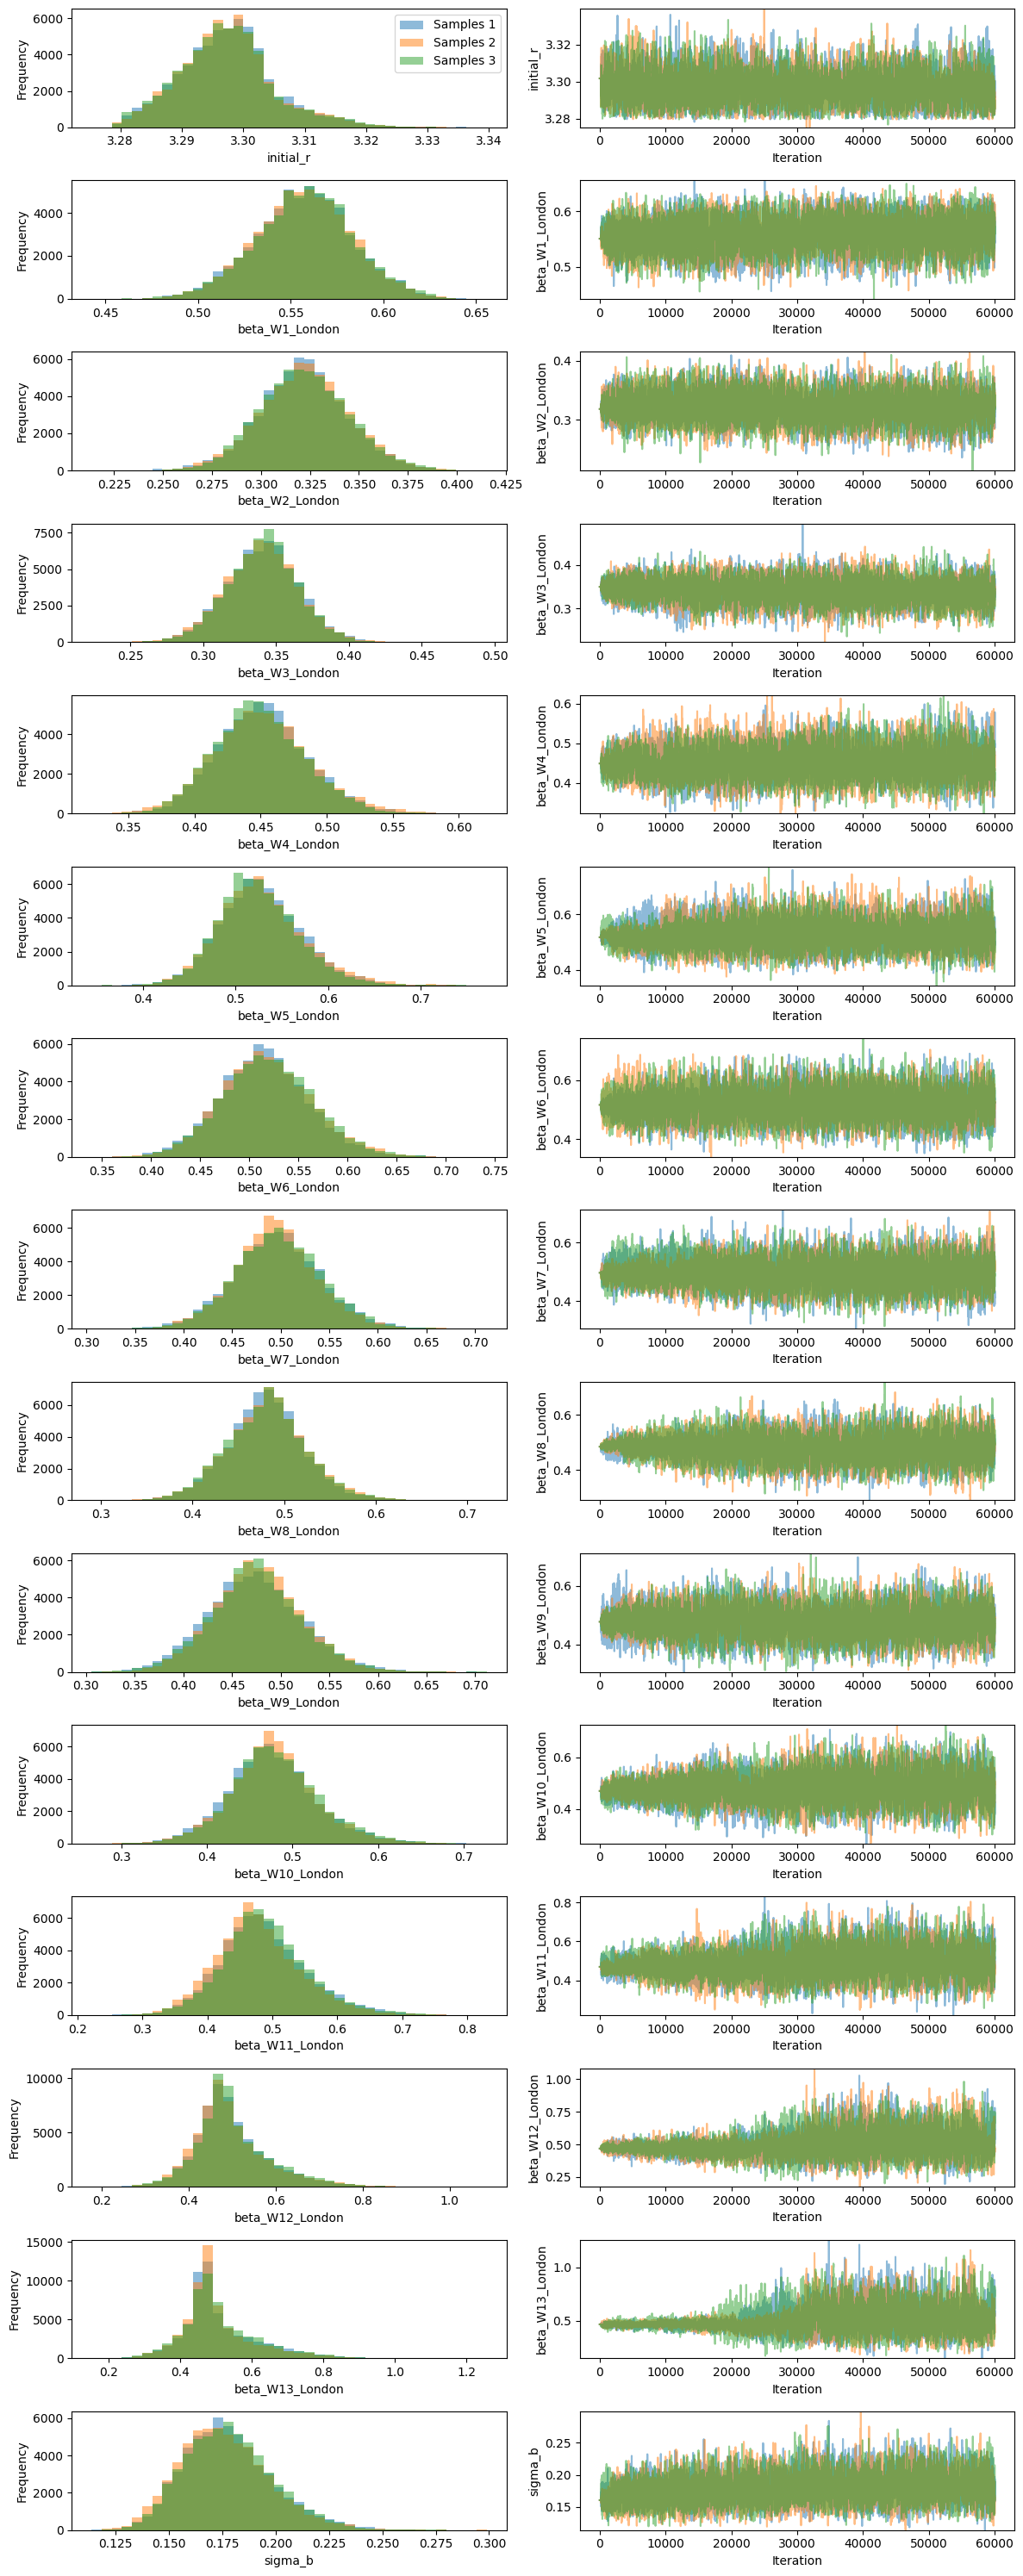

In [24]:
import pints.plot
 
# Plot histograms of the parameters inferred for London
param_names = ['initial_r']
param_names.extend(['beta_W{}_London'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(phe_var_samples, parameter_names=param_names)
plt.show()

In [25]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
phe_var_samples = phe_var_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(phe_var_samples))

[1.0027063  1.00095316 1.00255458 1.00565672 1.00215898 1.00347866
 1.00284528 1.00287607 1.00087318 1.00299675 1.00175063 1.00121626
 1.00087973 1.00201418 1.00216817]


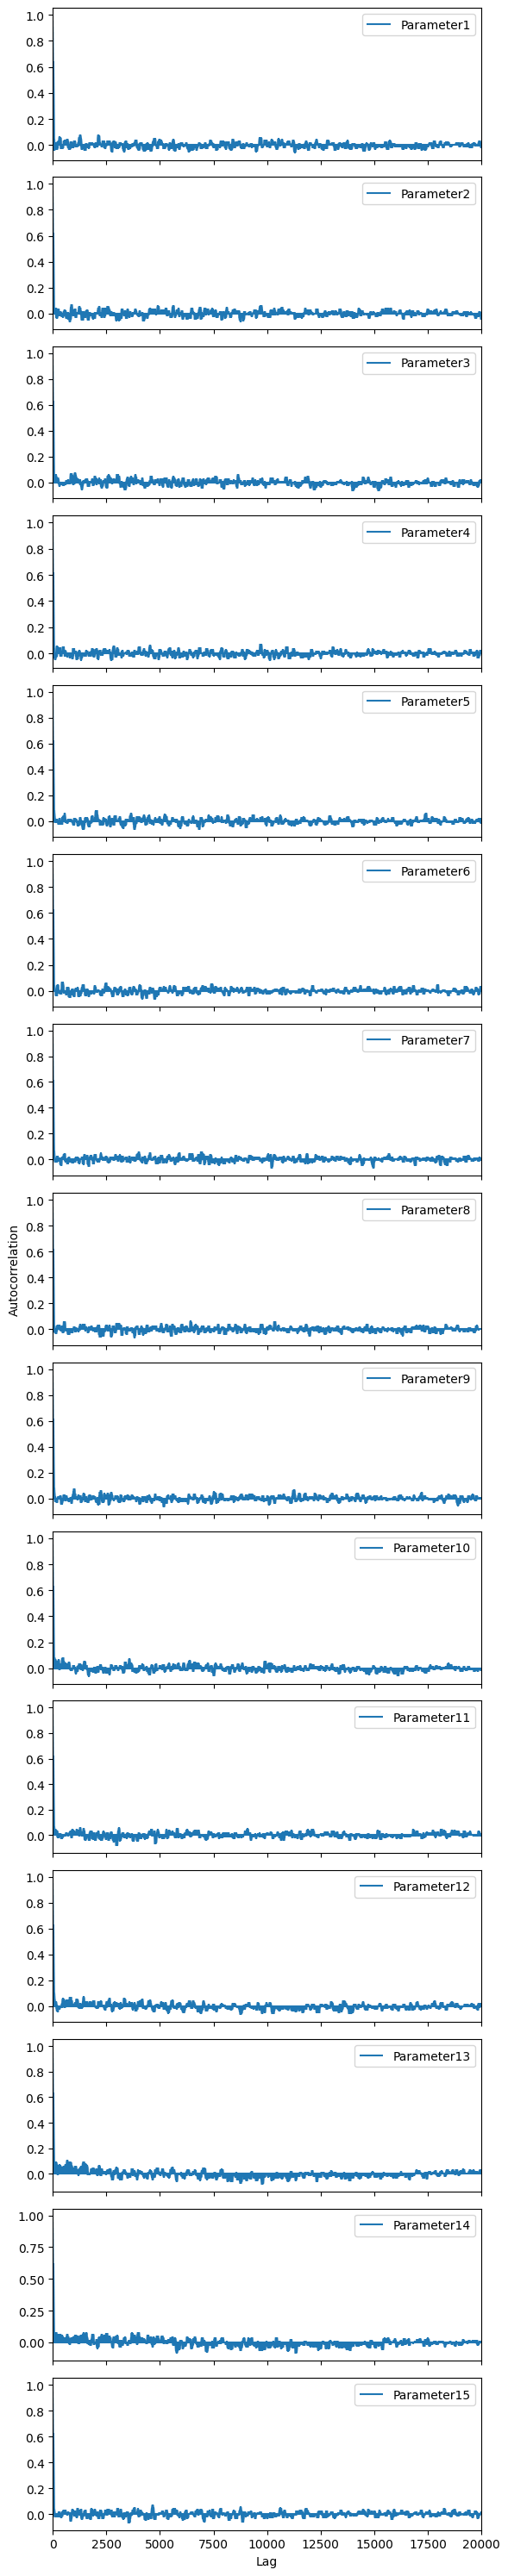

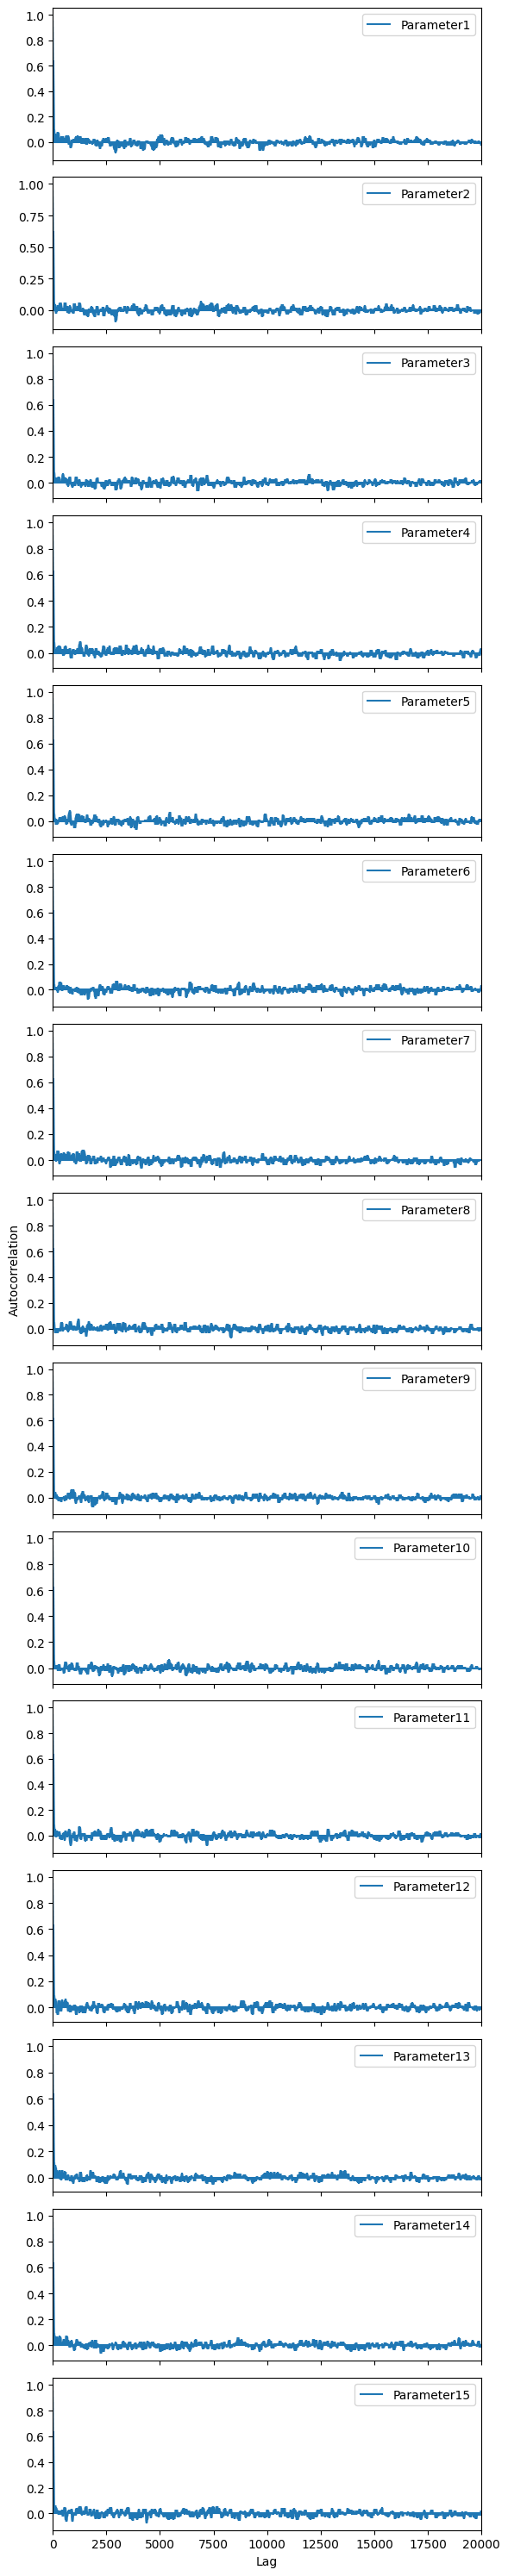

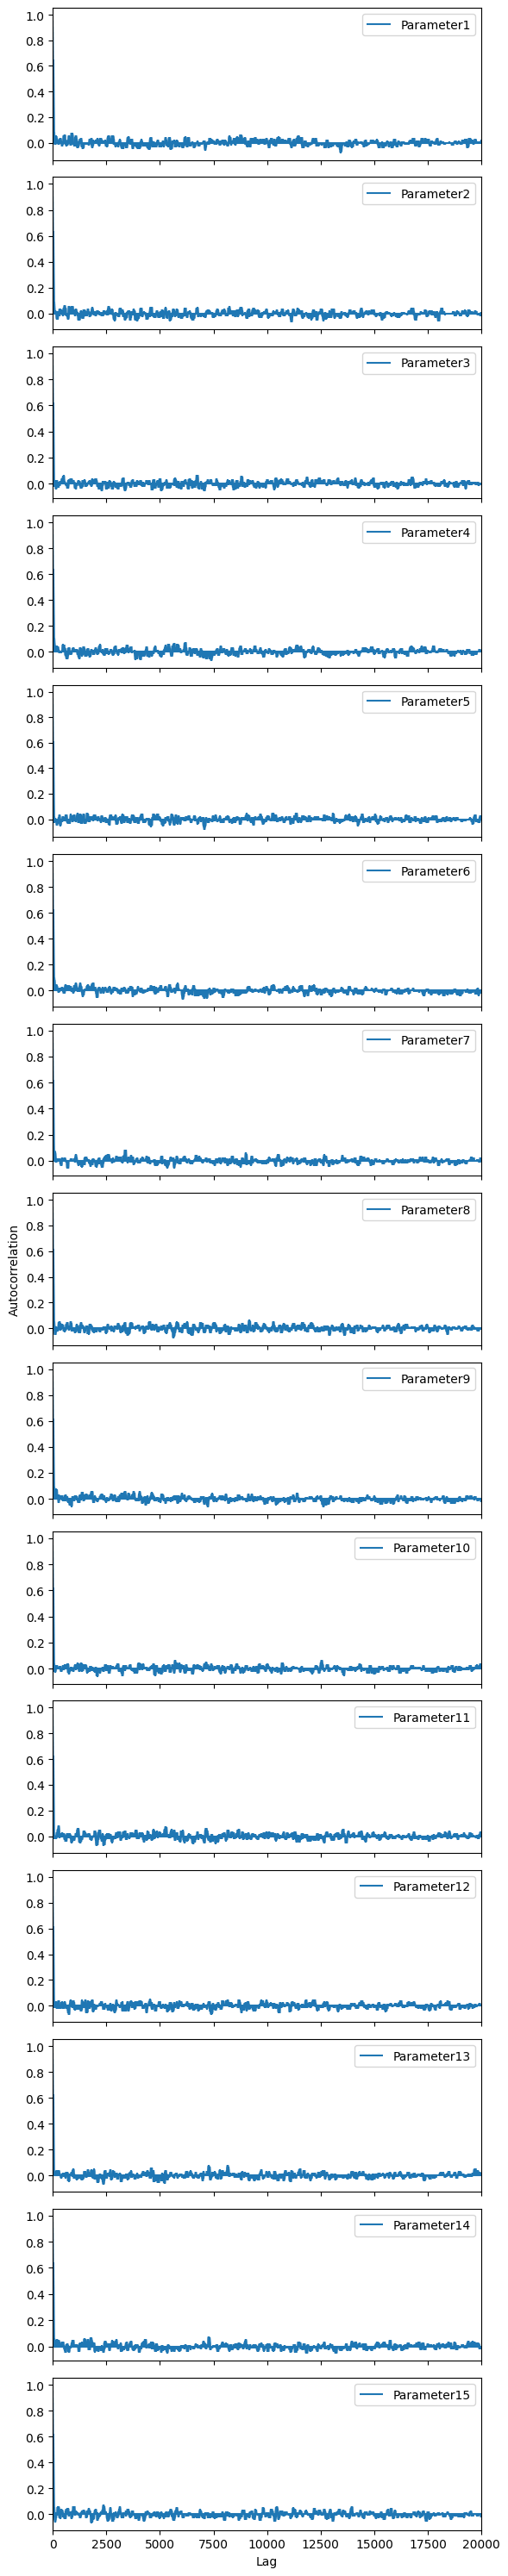

In [26]:
# Plot the autocorrelation for the three chains of parameters for South West
for phe_var_sample in phe_var_samples:
    pints.plot.autocorrelation(phe_var_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### PHE with variable contacts

In [27]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_var_samples.shape

phe_var_extended_samples = np.concatenate((phe_var_samples[0], phe_var_samples[1], phe_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

phe_var_predicted_new_infec = []
phe_var_predicted_deaths = []
phe_var_predicted_reprod_num = []

phe_fix_predicted_new_infec = []
phe_fix_predicted_deaths = []
phe_fix_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_var_reg_predicted_new_infec = []
    phe_var_reg_predicted_deaths = []
    phe_var_reg_predicted_reprod_num = []

    phe_model_var_parameters.regional_parameters.region_index = r+1
    phe_model_fix_parameters.regional_parameters.region_index = r+1

    for params in phe_var_extended_samples[::thinning, :]:
        phe_model_var_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_var.regions)
        LEN = len(np.arange(44, len(times), 7))

        betas = np.array(phe_model_var_parameters.regional_parameters.betas)
        for r in range(len(regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

        phe_model_var_parameters.regional_parameters.betas = betas.tolist()

        phe_var_r_fix = np.empty(len(times))
        phe_var_model_reg_deaths_data = np.empty(len(times))

        phe_var_m_fix = em.MultiTimesInfectivity(
            matrices_contact_var, time_changes_contact_var, regions, matrices_region_var, time_changes_region_var,
            phe_model_var_parameters.regional_parameters.initial_r, phe_model_var_parameters.disease_parameters.dI,
            phe_model_var_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_var_model_output = phe_model_var.simulate(phe_model_var_parameters)
        
        phe_var_age_model_reg_new_infections = phe_model_var.new_infections(phe_var_model_output)
        phe_var_model_reg_new_infections = phe_var_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_var_r_fix[t] = phe_var_m_fix.compute_reproduction_number(
                r+1, time, phe_var_model_output[t, :len(age_groups)],
                temp_variation=phe_model_var_parameters.regional_parameters.betas[r][t])
            phe_var_model_reg_deaths_data[t] = np.sum(phe_model_var.mean_deaths(
                fatality_ratio, time_to_death, t, phe_var_age_model_reg_new_infections))

        phe_var_reg_predicted_new_infec.append(phe_var_model_reg_new_infections)
        phe_var_reg_predicted_deaths.append(phe_var_model_reg_deaths_data)
        phe_var_reg_predicted_reprod_num.append(phe_var_r_fix)

    phe_var_reg_predicted_new_infec = np.array(phe_var_reg_predicted_new_infec)
 
    phe_var_predicted_new_infec.append(phe_var_reg_predicted_new_infec)
    phe_var_predicted_deaths.append(phe_var_reg_predicted_deaths)
    phe_var_predicted_reprod_num.append(phe_var_reg_predicted_reprod_num)

phe_var_predicted_new_infec = np.array(phe_var_predicted_new_infec)
phe_var_predicted_deaths = np.array(phe_var_predicted_deaths)
phe_var_predicted_reprod_num = np.array(phe_var_predicted_reprod_num)


/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_1316/1613986609.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  phe_var_r_fix[t] = phe_var_m_fix.compute_reproduction_number(


### PHE with fixed contacts

In [28]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_var_samples.shape

phe_var_extended_samples = np.concatenate((phe_var_samples[0], phe_var_samples[1], phe_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

phe_fix_predicted_new_infec = []
phe_fix_predicted_deaths = []
phe_fix_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_fix_reg_predicted_new_infec = []
    phe_fix_reg_predicted_deaths = []
    phe_fix_reg_predicted_reprod_num = []

    phe_model_fix_parameters.regional_parameters.region_index = r+1

    for params in phe_var_extended_samples[::thinning, :]:
        phe_model_fix_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model_fix.regions)
        
        phe_fix_r_fix = np.empty(len(times))
        phe_fix_model_reg_deaths_data = np.empty(len(times))

        phe_fix_m_fix = em.MultiTimesInfectivity(
            matrices_contact_fix, time_changes_contact_fix, regions, matrices_region_fix, time_changes_region_fix,
            phe_model_fix_parameters.regional_parameters.initial_r, phe_model_fix_parameters.disease_parameters.dI,
            phe_model_fix_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_fix_model_output = phe_model_fix.simulate(phe_model_fix_parameters)

        phe_fix_age_model_reg_new_infections = phe_model_fix.new_infections(phe_fix_model_output)
        phe_fix_model_reg_new_infections = phe_fix_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_fix_r_fix[t] = phe_fix_m_fix.compute_reproduction_number(
                r+1, time, phe_fix_model_output[t, :len(age_groups)],
                temp_variation=phe_model_fix_parameters.regional_parameters.betas[r][t])
            phe_fix_model_reg_deaths_data[t] = np.sum(phe_model_fix.mean_deaths(
                fatality_ratio, time_to_death, t, phe_fix_age_model_reg_new_infections))

        phe_fix_reg_predicted_new_infec.append(phe_fix_model_reg_new_infections)
        phe_fix_reg_predicted_deaths.append(phe_fix_model_reg_deaths_data)
        phe_fix_reg_predicted_reprod_num.append(phe_fix_r_fix)

    phe_fix_reg_predicted_new_infec = np.array(phe_fix_reg_predicted_new_infec)

    phe_fix_predicted_new_infec.append(phe_fix_reg_predicted_new_infec)
    phe_fix_predicted_deaths.append(phe_fix_reg_predicted_deaths)
    phe_fix_predicted_reprod_num.append(phe_fix_reg_predicted_reprod_num)

phe_fix_predicted_new_infec = np.array(phe_fix_predicted_new_infec)
phe_fix_predicted_deaths = np.array(phe_fix_predicted_deaths)
phe_fix_predicted_reprod_num = np.array(phe_fix_predicted_reprod_num)

### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### PHE with variable contacts

In [29]:
# Set up traces to plot
phe_var_new_infec_mean = []
phe_var_deaths_mean = []
phe_var_reprod_num_mean = []

phe_var_new_infec_upper = []
phe_var_deaths_upper = []
phe_var_reprod_num_upper = []

phe_var_new_infec_lower = []
phe_var_deaths_lower = []
phe_var_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_var_new_infec_mean.append(np.mean(phe_var_predicted_new_infec[r,:,:], axis=0))
    phe_var_deaths_mean.append(np.mean(phe_var_predicted_deaths[r,:,:], axis=0))
    phe_var_reprod_num_mean.append(np.mean(phe_var_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_var_new_infec_upper.append(np.quantile(phe_var_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_var_deaths_upper.append(np.quantile(phe_var_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_var_reprod_num_upper.append(np.quantile(phe_var_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_var_new_infec_lower.append(np.quantile(phe_var_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_var_deaths_lower.append(np.quantile(phe_var_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_var_reprod_num_lower.append(np.quantile(phe_var_predicted_reprod_num[r,:,:], 0.025, axis=0))

### PHE with fixed contacts

In [30]:
# Set up traces to plot
phe_fix_new_infec_mean = []
phe_fix_deaths_mean = []
phe_fix_reprod_num_mean = []

phe_fix_new_infec_upper = []
phe_fix_deaths_upper = []
phe_fix_reprod_num_upper = []

phe_fix_new_infec_lower = []
phe_fix_deaths_lower = []
phe_fix_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_fix_new_infec_mean.append(np.mean(phe_fix_predicted_new_infec[r,:,:], axis=0))
    phe_fix_deaths_mean.append(np.mean(phe_fix_predicted_deaths[r,:,:], axis=0))
    phe_fix_reprod_num_mean.append(np.mean(phe_fix_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_fix_new_infec_upper.append(np.quantile(phe_fix_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_fix_deaths_upper.append(np.quantile(phe_fix_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_fix_reprod_num_upper.append(np.quantile(phe_fix_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_fix_new_infec_lower.append(np.quantile(phe_fix_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_fix_deaths_lower.append(np.quantile(phe_fix_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_fix_reprod_num_lower.append(np.quantile(phe_fix_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche (with NPIs)

In [31]:
# Set random seed
np.random.seed(28)

In [32]:
# Initialise inference for the model
roche_inference_var = em.inference.RocheSEIRInfer(roche_model_var)

# Add model, death, tests and NPIs data to the inference structure
roche_inference_var.read_model_data(susceptibles, infectives)
roche_inference_var.read_deaths_data(deaths_data, deaths_times)
roche_inference_var.read_serology_data(tests, positives_data, serology_times, sens, spec)
roche_inference_var.read_npis_data(max_levels_npi, targeted_npi, general_npi_yes, reg_levels_npi_yes, time_changes_npi_yes, time_changes_flag_yes)

# Run inference structure
roche_var_samples = roche_inference_var.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -14739.6  -14739.6    0:00.4
1     12    -12864.67 -12864.67   0:00.7
2     18    -9893.751 -9893.751   0:01.1
3     24    -9893.751 -10890.73   0:01.4
20    126   -5701.166 -5701.166   0:06.4
40    246   -3744.263 -3744.282   0:13.8
60    366   -3744.258 -3744.258   0:21.6
80    486   -3744.258 -3744.258   0:29.3
100   606   -3744.258 -3744.258   0:37.1
120   726   -3744.258 -3744.258   0:44.9
135   810   -3744.258 -3744.258   0:50.3
Halting: No significant change for 100 iterations.
[0.03178126 0.94732467] -3744.2577323494675
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.
Iter. Eval.  Accept.   Accept.   Accept.   Time    
0     3       0         0         0          0:01.3
1     6       0         

### Quality check of the inference procedure

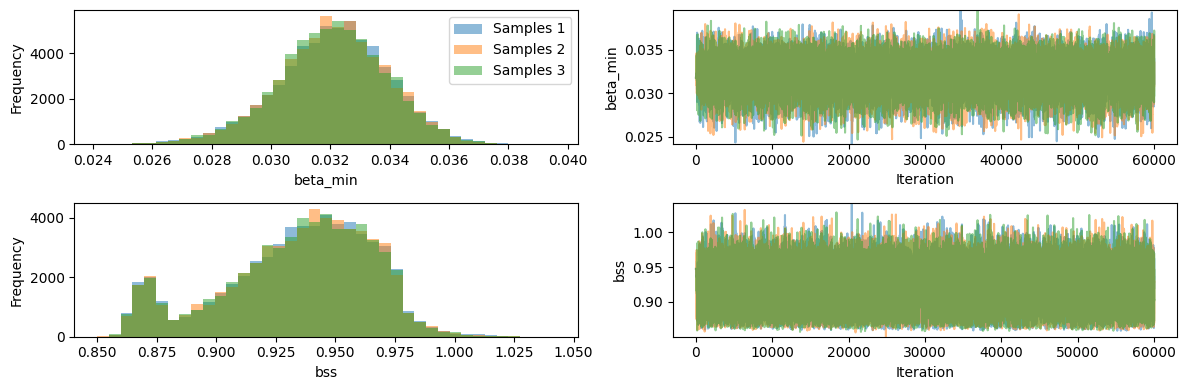

In [33]:
import pints.plot

# Plot histograms of the parameters inferred for South West
# param_names = ['Initial Pss']
# for age in model.age_groups:
#     param_names.append('kR_{}'.format(age))

# for age in model.age_groups:
#     param_names.append('Pa_{}'.format(age))
param_names=['beta_min', 'bss']

pints.plot.trace(roche_var_samples, parameter_names=param_names)
plt.show()

In [34]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
roche_var_samples = roche_var_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(roche_var_samples))

[1.00035384 1.00020418]


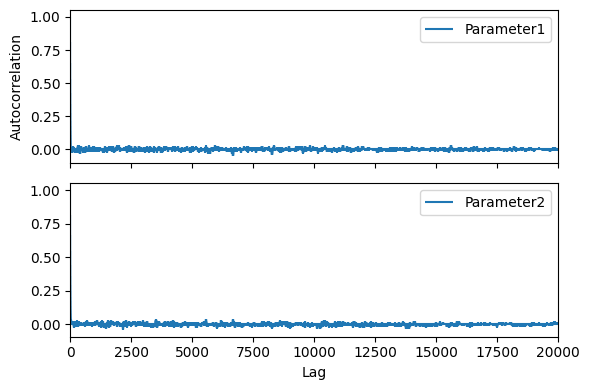

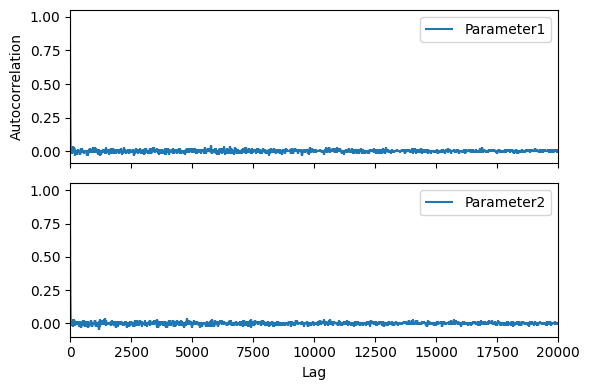

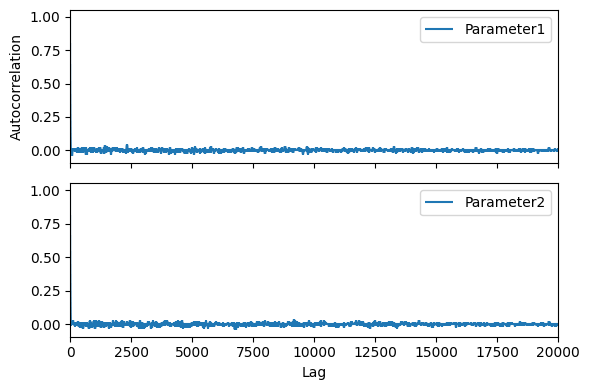

In [35]:
# Plot the autocorrelation for the three chains of parameters for South West
for roche_var_sample in roche_var_samples:
    pints.plot.autocorrelation(roche_var_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Roche with NPIs

In [36]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = roche_var_samples.shape

roche_var_extended_samples = np.concatenate((roche_var_samples[0], roche_var_samples[1], roche_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

roche_var_predicted_new_infec = []
roche_var_predicted_deaths = []
roche_var_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_var_reg_predicted_new_infec = []
    roche_var_reg_predicted_deaths = []
    roche_var_reg_predicted_reprod_num = []

    roche_model_var_parameters.simulation_parameters.region_index = r+1

    for params in roche_var_extended_samples[::thinning, :]:
        roche_model_var_parameters.transmission_parameters.beta_min = params[0]
        roche_model_var_parameters.transmission_parameters.bss = params[1]
        
        #roche_var_r_fix = np.empty(len(times))
        roche_var_model_reg_deaths_data = np.empty(len(times))

        #roche_var_m_fix = em.MultiTimesInfectivity(
        #    matrices_contact_var, time_changes_contact_var, regions, matrices_region_var, time_changes_region_var,
        #    roche_model_var_parameters.regional_parameters.initial_r, roche_model_var_parameters.disease_parameters.dI,
        #    roche_model_var_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        roche_var_model_output = roche_model_var.simulate(roche_model_var_parameters)
        
        roche_var_age_model_reg_new_infections = roche_model_var.new_infections(roche_var_model_output)
        roche_var_model_reg_new_infections = roche_var_age_model_reg_new_infections.sum(axis=1)

        roche_var_age_model_reg_new_deaths = roche_model_var.new_deaths(roche_var_model_output)
        
        for t, time in enumerate(times):
            #roche_var_r_fix[t] = roche_var_m_fix.compute_reproduction_number(
            #    r+1, time, roche_var_model_output[t, :len(age_groups)],
            #    temp_variation=roche_model_var_parameters.regional_parameters.betas[r][t])
            roche_var_model_reg_deaths_data[t] = np.sum(roche_model_var.mean_deaths(
                t, roche_var_age_model_reg_new_deaths))

        roche_var_reg_predicted_new_infec.append(roche_var_model_reg_new_infections)
        roche_var_reg_predicted_deaths.append(roche_var_model_reg_deaths_data)
        #roche_var_reg_predicted_reprod_num.append(roche_var_r_fix)

    roche_var_reg_predicted_new_infec = np.array(roche_var_reg_predicted_new_infec)
 
    roche_var_predicted_new_infec.append(roche_var_reg_predicted_new_infec)
    roche_var_predicted_deaths.append(roche_var_reg_predicted_deaths)
    #roche_var_predicted_reprod_num.append(roche_var_reg_predicted_reprod_num)

roche_var_predicted_new_infec = np.array(roche_var_predicted_new_infec)
roche_var_predicted_deaths = np.array(roche_var_predicted_deaths)
#roche_var_predicted_reprod_num = np.array(roche_var_predicted_reprod_num)


### Roche with no NPIs

In [37]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = roche_var_samples.shape

roche_var_extended_samples = np.concatenate((roche_var_samples[0], roche_var_samples[1], roche_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

roche_fix_predicted_new_infec = []
roche_fix_predicted_deaths = []
roche_fix_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_fix_reg_predicted_new_infec = []
    roche_fix_reg_predicted_deaths = []
    roche_fix_reg_predicted_reprod_num = []

    roche_model_fix_parameters.simulation_parameters.region_index = r+1

    for params in roche_var_extended_samples[::thinning, :]:
        roche_model_fix_parameters.transmission_parameters.beta_min = params[0]
        roche_model_fix_parameters.transmission_parameters.bss = params[1]
        
        #roche_fix_r_fix = np.empty(len(times))
        roche_fix_model_reg_deaths_data = np.empty(len(times))

        #roche_fix_m_fix = em.MultiTimesInfectivity(
        #    matrices_contact_fix, time_changes_contact_fix, regions, matrices_region_fix, time_changes_region_fix,
        #    roche_model_fix_parameters.regional_parameters.initial_r, roche_model_fix_parameters.disease_parameters.dI,
        #    roche_model_fix_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        roche_fix_model_output = roche_model_fix.simulate(roche_model_fix_parameters)
        
        roche_fix_age_model_reg_new_infections = roche_model_fix.new_infections(roche_fix_model_output)
        roche_fix_model_reg_new_infections = roche_fix_age_model_reg_new_infections.sum(axis=1)

        roche_fix_age_model_reg_new_deaths = roche_model_fix.new_deaths(roche_fix_model_output)
        
        for t, time in enumerate(times):
            #roche_fix_r_fix[t] = roche_fix_m_fix.compute_reproduction_number(
            #    r+1, time, roche_fix_model_output[t, :len(age_groups)],
            #    temp_variation=roche_model_fix_parameters.regional_parameters.betas[r][t])
            roche_fix_model_reg_deaths_data[t] = np.sum(roche_model_fix.mean_deaths(
                t, roche_fix_age_model_reg_new_deaths))

        roche_fix_reg_predicted_new_infec.append(roche_fix_model_reg_new_infections)
        roche_fix_reg_predicted_deaths.append(roche_fix_model_reg_deaths_data)
        #roche_fix_reg_predicted_reprod_num.append(roche_fix_r_fix)

    roche_fix_reg_predicted_new_infec = np.array(roche_fix_reg_predicted_new_infec)
 
    roche_fix_predicted_new_infec.append(roche_fix_reg_predicted_new_infec)
    roche_fix_predicted_deaths.append(roche_fix_reg_predicted_deaths)
    #roche_fix_predicted_reprod_num.append(roche_fix_reg_predicted_reprod_num)

roche_fix_predicted_new_infec = np.array(roche_fix_predicted_new_infec)
roche_fix_predicted_deaths = np.array(roche_fix_predicted_deaths)
#roche_fix_predicted_reprod_num = np.array(roche_fix_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Roche with NPIs

In [38]:
# Set up traces to plot
roche_var_new_infec_mean = []
roche_var_deaths_mean = []
roche_var_reprod_num_mean = []

roche_var_new_infec_upper = []
roche_var_deaths_upper = []
roche_var_reprod_num_upper = []

roche_var_new_infec_lower = []
roche_var_deaths_lower = []
roche_var_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_var_new_infec_mean.append(np.mean(roche_var_predicted_new_infec[r,:,:], axis=0))
    roche_var_deaths_mean.append(np.mean(roche_var_predicted_deaths[r,:,:], axis=0))
    #roche_var_reprod_num_mean.append(np.mean(roche_var_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_var_new_infec_upper.append(np.quantile(roche_var_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_var_deaths_upper.append(np.quantile(roche_var_predicted_deaths[r,:,:], 0.975, axis=0))
    #roche_var_reprod_num_upper.append(np.quantile(roche_var_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_var_new_infec_lower.append(np.quantile(roche_var_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_var_deaths_lower.append(np.quantile(roche_var_predicted_deaths[r,:,:], 0.025, axis=0))
    #roche_var_reprod_num_lower.append(np.quantile(roche_var_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Roche without NPIs

In [39]:
# Set up traces to plot
roche_fix_new_infec_mean = []
roche_fix_deaths_mean = []
roche_fix_reprod_num_mean = []

roche_fix_new_infec_upper = []
roche_fix_deaths_upper = []
roche_fix_reprod_num_upper = []

roche_fix_new_infec_lower = []
roche_fix_deaths_lower = []
roche_fix_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_fix_new_infec_mean.append(np.mean(roche_fix_predicted_new_infec[r,:,:], axis=0))
    roche_fix_deaths_mean.append(np.mean(roche_fix_predicted_deaths[r,:,:], axis=0))
    #roche_fix_reprod_num_mean.append(np.mean(roche_fix_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_fix_new_infec_upper.append(np.quantile(roche_fix_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_fix_deaths_upper.append(np.quantile(roche_fix_predicted_deaths[r,:,:], 0.975, axis=0))
    #roche_fix_reprod_num_upper.append(np.quantile(roche_fix_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_fix_new_infec_lower.append(np.quantile(roche_fix_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_fix_deaths_lower.append(np.quantile(roche_fix_predicted_deaths[r,:,:], 0.025, axis=0))
    #roche_fix_reprod_num_lower.append(np.quantile(roche_fix_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Warwick Household (with variable contacts)

In [40]:
warwick_model_var.simulate(warwick_model_var_parameters)
warwick_model_fix.simulate(warwick_model_fix_parameters)

# Set random seed
np.random.seed(28)

In [41]:
# Initialise inference for the model
warwick_inference_var = em.inference.WarwickSEIRInfer(warwick_model_var)

# Add model, death, tests and NPIs data to the inference structure
warwick_inference_var.read_model_data(
    susceptibles, 
    update_age_groups(pop, (10 * extended_infectives_prop).astype(int)).tolist())
warwick_inference_var.read_extended_population_structure(extended_susceptibles, extended_infectives_prop)
warwick_inference_var.read_extended_contact_matrices(
    extended_house_cont_mat, extended_school_cont_mat,
    extended_work_cont_mat, extended_other_cont_mat)
warwick_inference_var.read_deaths_data(deaths_data, deaths_times)
warwick_inference_var.read_delay_data(pDtoH, dDtoH, pHtoDeath, dHtoDeath)
warwick_inference_var.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run inference structure
warwick_var_samples = warwick_inference_var.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 10


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Iter. Eval. Best      Current   Time    
0     10    -52117.95 -52117.95   0:00.7


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3829: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


1     20    -51153.13 -51153.13   0:01.8
2     30    -50905.48 -50905.48   0:02.9
3     40    -50192.98 -50192.98   0:04.2
20    210   -15936.81 -19314.87   0:23.1


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


40    410   -1934.661 -22914.2    0:35.4
60    610   -1428.514 -1511.857   0:52.2
80    810   -1400.75  -1400.75    1:22.3
100   1010  -1390.637 -1390.95    1:50.0
120   1210  -1380.796 -1380.796   2:14.7
140   1410  -1377.839 -1380.112   2:35.3
160   1610  -1377.594 -1379.141   2:59.1
180   1810  -1377.393 -1378.665   3:25.2
200   2010  -1376.729 -1376.729   3:52.8
220   2210  -1376.505 -1376.505   4:20.4
240   2410  -1376.076 -1376.13    4:44.5
260   2610  -1375.858 -1375.858   5:11.6
280   2810  -1375.645 -1375.645   5:39.7
300   3010  -1375.32  -1375.34    6:03.1
320   3210  -1374.684 -1374.684   6:32.6
340   3410  -1374.04  -1374.04    7:04.7
360   3610  -1373.032 -1373.032   7:33.6
380   3810  -1371.785 -1371.785   8:06.1
400   4010  -1369.407 -1369.407   8:38.0
420   4210  -1365.888 -1365.888   9:10.7
440   4410  -1363.506 -1363.802   9:37.4
460   4610  -1357.209 -1357.209  10:02.3
480   4810  -1351.756 -1351.776  10:31.9
500   5010  -1348.999 -1348.999  10:58.7
520   5210  -134

### Quality check of the inference procedure

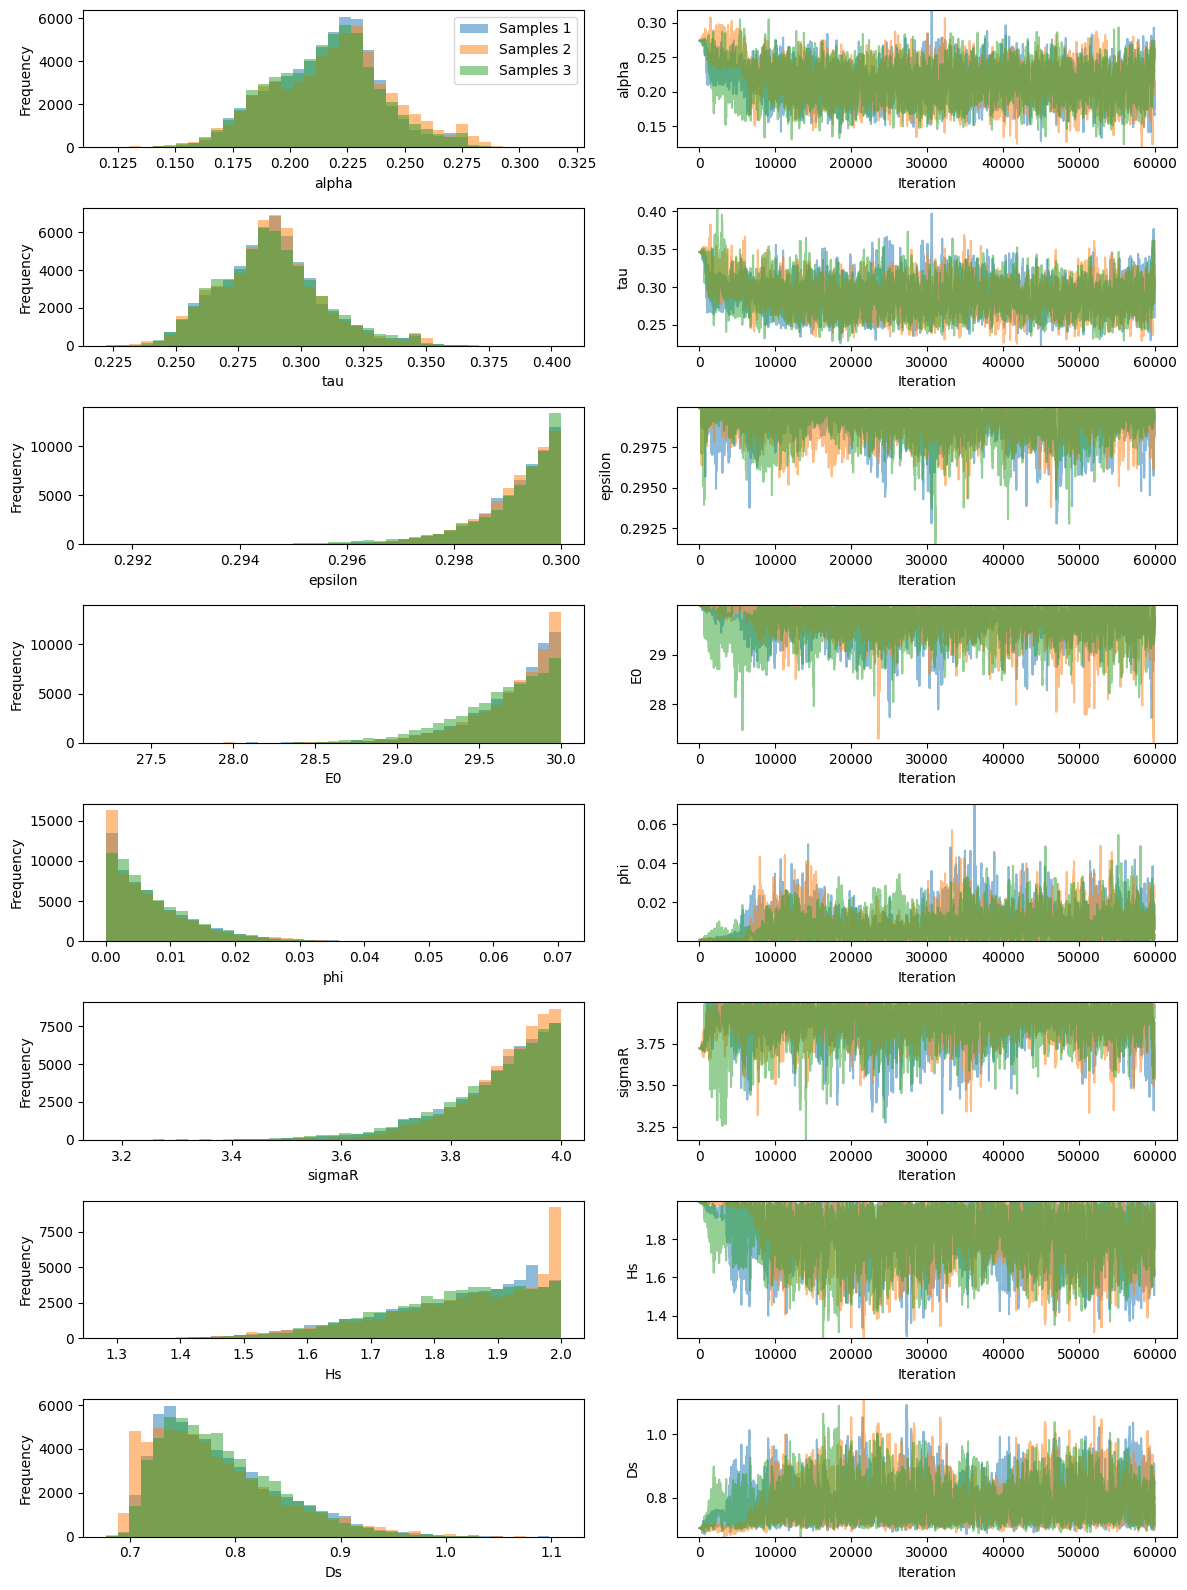

In [42]:
import pints.plot

# Plot histograms of the parameters inferred for South West
# param_names = ['Initial Pss']
# for age in model.age_groups:
#     param_names.append('kR_{}'.format(age))

# for age in model.age_groups:
#     param_names.append('Pa_{}'.format(age))
param_names=['alpha', 'tau', 'epsilon', 'E0', 'phi', 'sigmaR', 'Hs', 'Ds']

pints.plot.trace(warwick_var_samples, parameter_names=param_names)
plt.show()

In [43]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
warwick_var_samples = warwick_var_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(warwick_var_samples))

[1.0020582  1.00597323 1.00528462 1.01009773 1.00452227 1.00491067
 1.00946169 1.01097961]


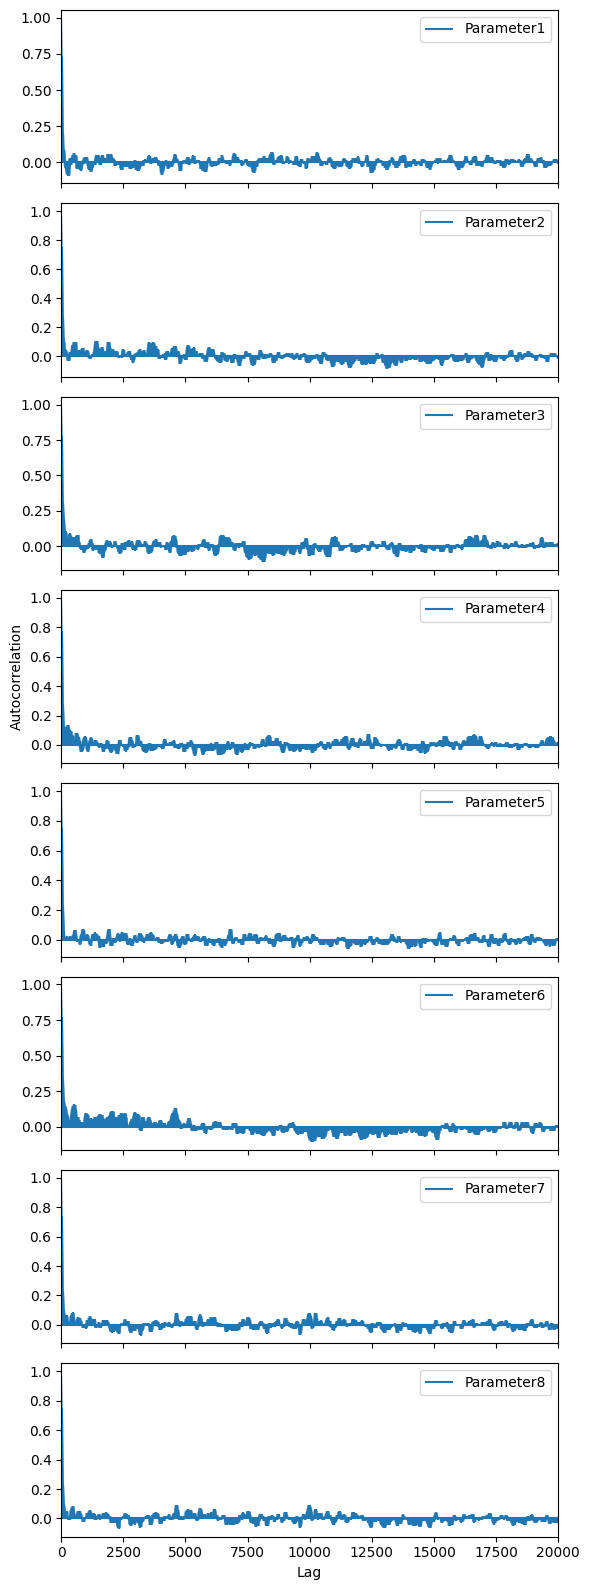

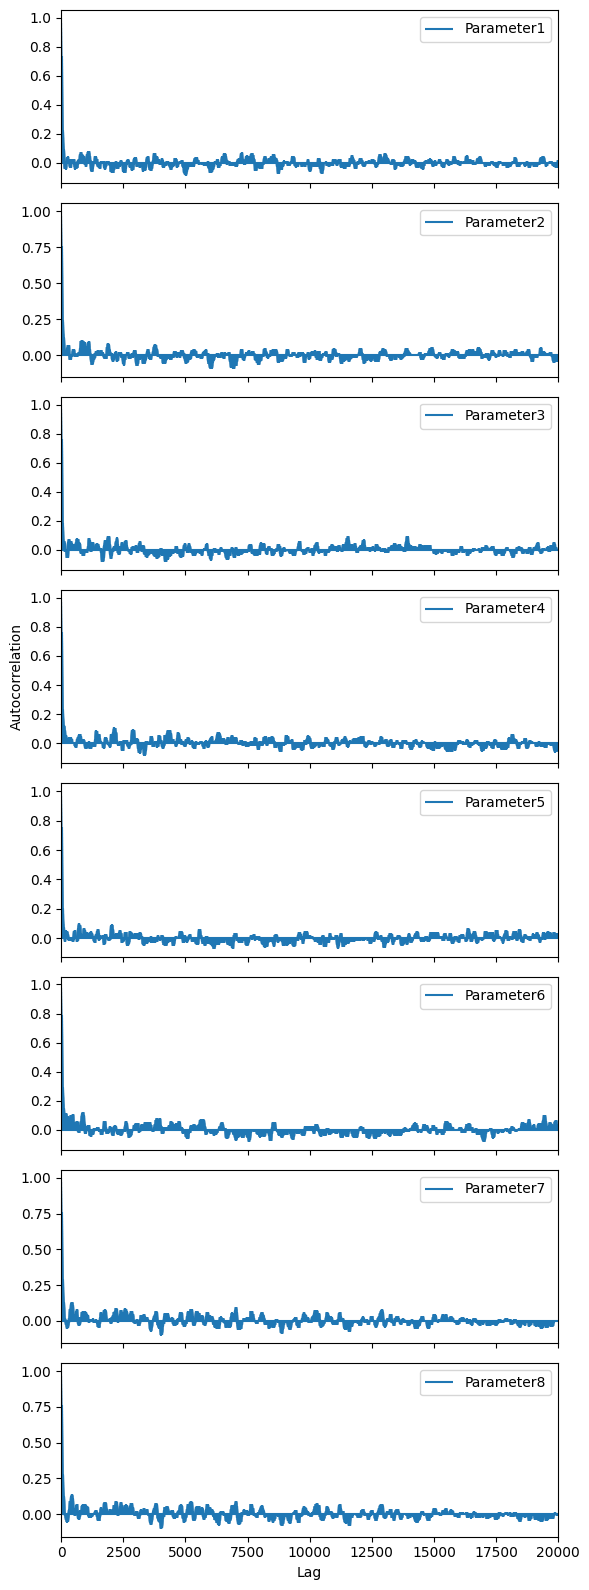

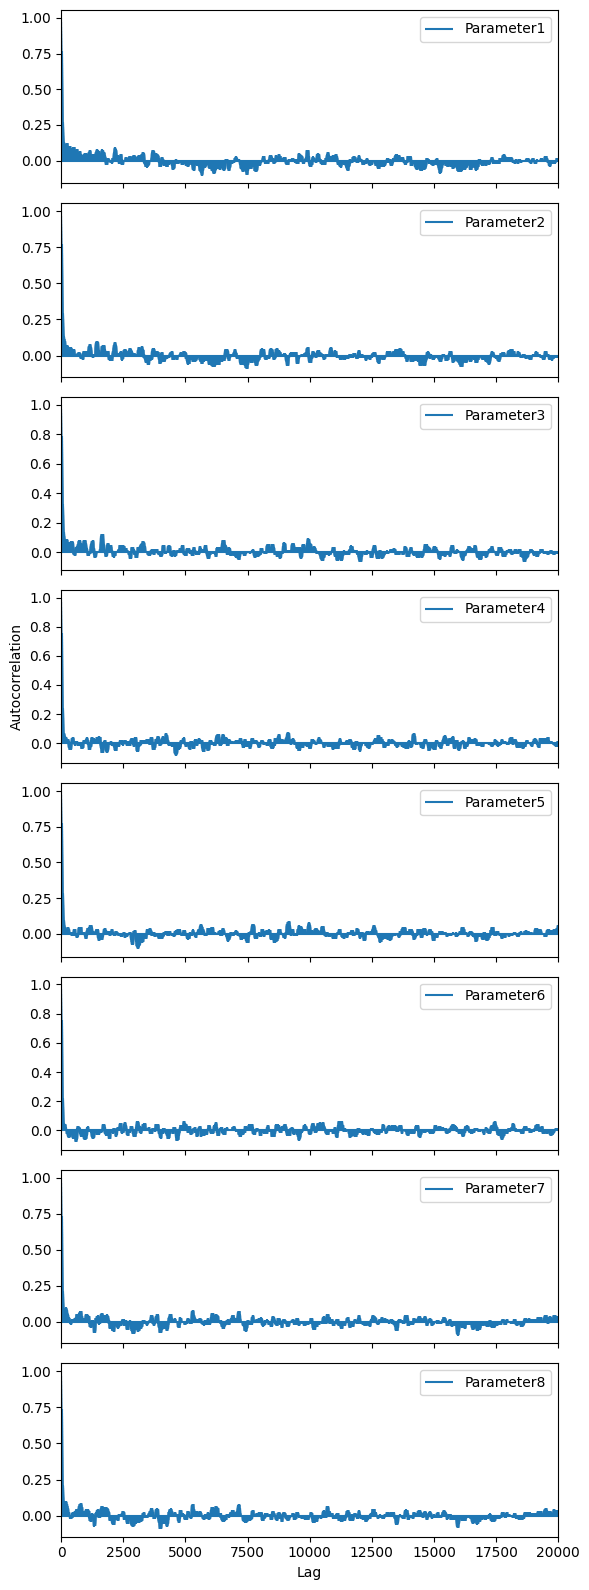

In [44]:
# Plot the autocorrelation for the three chains of parameters for South West
for warwick_var_sample in warwick_var_samples:
    pints.plot.autocorrelation(warwick_var_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths

### Warwick Household with variable contacts

In [45]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = warwick_var_samples.shape

warwick_var_extended_samples = np.concatenate((warwick_var_samples[0], warwick_var_samples[1], warwick_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

warwick_var_predicted_new_infec = []
warwick_var_predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_var_reg_predicted_new_infec = []
    warwick_var_reg_predicted_deaths = []
    warwick_var_reg_predicted_reprod_num = []

    warwick_model_var_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_var_extended_samples[::thinning, :]:
        d, sigma, gamma = warwick_inference_var.ll.compute_updated_param(params[0], params[1])
        E0R = params[3]
        M_from_to_HAT = warwick_inference_var.ll._compute_next_gen_matrix(d, sigma, params[1])

        eigvals, eigvecs = np.linalg.eig(M_from_to_HAT)

        reprod_number_0, i = np.max(abs(eigvals)), np.argmax(abs(eigvals))
        reprod_number_0 = reprod_number_0 / gamma
        Age_structure = abs(eigvecs[:, i])

        exposed_0 = Age_structure / np.sum(Age_structure)
        detected_0 = Age_structure / np.sum(Age_structure)
        undetected_0 = Age_structure / np.sum(Age_structure)

        warwick_model_var_parameters.ICs.exposed_1_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_var_parameters.ICs.exposed_2_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_var_parameters.ICs.exposed_3_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_var_parameters.ICs.detected_f = [stack_age_groups(np.array(susceptibles),  E0R * detected_0, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_var_parameters.ICs.undetected_f = [stack_age_groups(np.array(susceptibles),  E0R * undetected_0, r).tolist()
            for r, _ in enumerate(regions)]

        warwick_model_var_parameters.disease_parameters.tau = params[1]
        warwick_model_var_parameters.disease_parameters.d = update_age_groups(extended_susceptibles, d)

        warwick_model_var_parameters.transmission_parameters.epsilon = params[2]
        warwick_model_var_parameters.transmission_parameters.gamma = gamma
        warwick_model_var_parameters.transmission_parameters.sigma = params[5] * update_age_groups(extended_susceptibles, sigma)

        warwick_model_var_parameters.soc_dist_parameters.phi = params[4]
        
        #r_fix = np.empty(len(times))
        warwick_var_model_reg_deaths_data = np.empty(len(times))

        #m_fix = em.MultiTimesInfectivity(
        #    matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

        # Run model and number of new infections for all age groups
        warwick_var_model_output = warwick_model_var.simulate(warwick_model_var_parameters)

        warwick_var_age_model_reg_new_infections = warwick_model_var.new_infections(warwick_var_model_output)
        warwick_var_model_reg_new_infections = warwick_var_age_model_reg_new_infections.sum(axis=1)

        warwick_var_age_model_reg_new_hosp = warwick_model_var.new_hospitalisations(warwick_var_age_model_reg_new_infections, params[6] * pDtoH, dDtoH)
        warwick_var_model_reg_new_hosp = warwick_var_age_model_reg_new_hosp.sum(axis=1)

        warwick_var_age_model_reg_new_deaths = warwick_model_var.new_deaths(warwick_var_age_model_reg_new_hosp, params[7] * pHtoDeath, dHtoDeath)

        for t, time in enumerate(times):
        #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
            warwick_var_model_reg_deaths_data[t] = np.sum(warwick_model_var.mean_deaths(t, warwick_var_age_model_reg_new_deaths))
        
        warwick_var_reg_predicted_new_infec.append(warwick_var_model_reg_new_infections)
        warwick_var_reg_predicted_deaths.append(warwick_var_model_reg_deaths_data)
        #reg_predicted_reprod_num.append(r_fix)

    warwick_var_reg_predicted_new_infec = np.array(warwick_var_reg_predicted_new_infec)

    warwick_var_predicted_new_infec.append(warwick_var_reg_predicted_new_infec)
    warwick_var_predicted_deaths.append(warwick_var_reg_predicted_deaths)
    #predicted_reprod_num.append(reg_predicted_reprod_num)

warwick_var_predicted_new_infec = np.array(warwick_var_predicted_new_infec)
warwick_var_predicted_deaths = np.array(warwick_var_predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)


In [46]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = warwick_var_samples.shape

warwick_var_extended_samples = np.concatenate((warwick_var_samples[0], warwick_var_samples[1], warwick_var_samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

warwick_fix_predicted_new_infec = []
warwick_fix_predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_fix_reg_predicted_new_infec = []
    warwick_fix_reg_predicted_deaths = []
    warwick_fix_reg_predicted_reprod_num = []

    warwick_model_fix_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_var_extended_samples[::thinning, :]:
        d, sigma, gamma = warwick_inference_var.ll.compute_updated_param(params[0], params[1])
        E0R = params[3]
        M_from_to_HAT = warwick_inference_var.ll._compute_next_gen_matrix(d, sigma, params[1])

        eigvals, eigvecs = np.linalg.eig(M_from_to_HAT)

        reprod_number_0, i = np.max(abs(eigvals)), np.argmax(abs(eigvals))
        reprod_number_0 = reprod_number_0 / gamma
        Age_structure = abs(eigvecs[:, i])

        exposed_0 = Age_structure / np.sum(Age_structure)
        detected_0 = Age_structure / np.sum(Age_structure)
        undetected_0 = Age_structure / np.sum(Age_structure)

        warwick_model_fix_parameters.ICs.exposed_1_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_fix_parameters.ICs.exposed_2_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_fix_parameters.ICs.exposed_3_f = [stack_age_groups(np.array(susceptibles),  E0R * exposed_0/3, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_fix_parameters.ICs.detected_f = [stack_age_groups(np.array(susceptibles),  E0R * detected_0, r).tolist()
            for r, _ in enumerate(regions)]
        warwick_model_fix_parameters.ICs.undetected_f = [stack_age_groups(np.array(susceptibles),  E0R * undetected_0, r).tolist()
            for r, _ in enumerate(regions)]

        warwick_model_fix_parameters.disease_parameters.tau = params[1]
        warwick_model_fix_parameters.disease_parameters.d = update_age_groups(extended_susceptibles, d)

        warwick_model_fix_parameters.transmission_parameters.epsilon = params[2]
        warwick_model_fix_parameters.transmission_parameters.gamma = gamma
        warwick_model_fix_parameters.transmission_parameters.sigma = params[5] * update_age_groups(extended_susceptibles, sigma)

        warwick_model_fix_parameters.soc_dist_parameters.phi = 0
        
        #r_fix = np.empty(len(times))
        warwick_fix_model_reg_deaths_data = np.empty(len(times))

        #m_fix = em.MultiTimesInfectivity(
        #    matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

        # Run model and number of new infections for all age groups
        warwick_fix_model_output = warwick_model_fix.simulate(warwick_model_fix_parameters)

        warwick_fix_age_model_reg_new_infections = warwick_model_fix.new_infections(warwick_fix_model_output)
        warwick_fix_model_reg_new_infections = warwick_fix_age_model_reg_new_infections.sum(axis=1)

        warwick_fix_age_model_reg_new_hosp = warwick_model_fix.new_hospitalisations(warwick_fix_age_model_reg_new_infections, params[6] * pDtoH, dDtoH)
        warwick_fix_model_reg_new_hosp = warwick_fix_age_model_reg_new_hosp.sum(axis=1)

        warwick_fix_age_model_reg_new_deaths = warwick_model_fix.new_deaths(warwick_fix_age_model_reg_new_hosp, params[7] * pHtoDeath, dHtoDeath)

        for t, time in enumerate(times):
        #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_fixiation=parameters[8][r][t])
            warwick_fix_model_reg_deaths_data[t] = np.sum(warwick_model_fix.mean_deaths(t, warwick_fix_age_model_reg_new_deaths))
        
        warwick_fix_reg_predicted_new_infec.append(warwick_fix_model_reg_new_infections)
        warwick_fix_reg_predicted_deaths.append(warwick_fix_model_reg_deaths_data)
        #reg_predicted_reprod_num.append(r_fix)

    warwick_fix_reg_predicted_new_infec = np.array(warwick_fix_reg_predicted_new_infec)

    warwick_fix_predicted_new_infec.append(warwick_fix_reg_predicted_new_infec)
    warwick_fix_predicted_deaths.append(warwick_fix_reg_predicted_deaths)
    #predicted_reprod_num.append(reg_predicted_reprod_num)

warwick_fix_predicted_new_infec = np.array(warwick_fix_predicted_new_infec)
warwick_fix_predicted_deaths = np.array(warwick_fix_predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Warwick Household with variable contacts

In [47]:
# Set up traces to plot
warwick_var_new_infec_mean = []
warwick_var_deaths_mean = []
warwick_var_reprod_num_mean = []

warwick_var_new_infec_upper = []
warwick_var_deaths_upper = []
warwick_var_reprod_num_upper = []

warwick_var_new_infec_lower = []
warwick_var_deaths_lower = []
warwick_var_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_var_new_infec_mean.append(np.mean(warwick_var_predicted_new_infec[r,:,:], axis=0))
    warwick_var_deaths_mean.append(np.mean(warwick_var_predicted_deaths[r,:,:], axis=0))
    #warwick_var_reprod_num_mean.append(np.mean(warwick_var_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_var_new_infec_upper.append(np.quantile(warwick_var_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_var_deaths_upper.append(np.quantile(warwick_var_predicted_deaths[r,:,:], 0.975, axis=0))
    #warwick_var_reprod_num_upper.append(np.quantile(warwick_var_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_var_new_infec_lower.append(np.quantile(warwick_var_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_var_deaths_lower.append(np.quantile(warwick_var_predicted_deaths[r,:,:], 0.025, axis=0))
    #warwick_var_reprod_num_lower.append(np.quantile(warwick__var_predicted_reprod_num[r,:,:], 0.025, axis=0))

### Warwick Household with fixed contacts

In [48]:
# Set up traces to plot
warwick_fix_new_infec_mean = []
warwick_fix_deaths_mean = []
warwick_fix_reprod_num_mean = []

warwick_fix_new_infec_upper = []
warwick_fix_deaths_upper = []
warwick_fix_reprod_num_upper = []

warwick_fix_new_infec_lower = []
warwick_fix_deaths_lower = []
warwick_fix_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_fix_new_infec_mean.append(np.mean(warwick_fix_predicted_new_infec[r,:,:], axis=0))
    warwick_fix_deaths_mean.append(np.mean(warwick_fix_predicted_deaths[r,:,:], axis=0))
    # warwick_fix_reprod_num_mean.append(np.mean(warwick_fix_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_fix_new_infec_upper.append(np.quantile(warwick_fix_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_fix_deaths_upper.append(np.quantile(warwick_fix_predicted_deaths[r,:,:], 0.975, axis=0))
    # warwick_fix_reprod_num_upper.append(np.quantile(warwick_fix_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_fix_new_infec_lower.append(np.quantile(warwick_fix_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_fix_deaths_lower.append(np.quantile(warwick_fix_predicted_deaths[r,:,:], 0.025, axis=0))
    # warwick_fix_reprod_num_lower.append(np.quantile(warwick_fix_predicted_reprod_num[r,:,:], 0.025, axis=0))

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [49]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
new_infec_mean = [
    phe_var_new_infec_mean, phe_fix_new_infec_mean,
    roche_var_new_infec_mean, roche_fix_new_infec_mean,
    warwick_var_new_infec_mean, warwick_fix_new_infec_mean]
new_infec_upper = [
    phe_var_new_infec_upper, phe_fix_new_infec_upper,
    roche_var_new_infec_upper, roche_fix_new_infec_upper,
    warwick_var_new_infec_upper, warwick_fix_new_infec_upper]
new_infec_lower = [
    phe_var_new_infec_lower, phe_fix_new_infec_lower,
    roche_var_new_infec_lower, roche_fix_new_infec_lower,
    warwick_var_new_infec_lower, warwick_fix_new_infec_lower]

deaths_mean = [
    phe_var_deaths_mean, phe_fix_deaths_mean,
    roche_var_deaths_mean, roche_fix_deaths_mean,
    warwick_var_deaths_mean, warwick_fix_deaths_mean,]
deaths_upper = [
    phe_var_deaths_upper, phe_fix_deaths_upper,
    roche_var_deaths_upper, roche_fix_deaths_upper,
    warwick_var_deaths_upper, warwick_fix_deaths_upper]
deaths_lower = [
    phe_var_deaths_lower, phe_fix_deaths_lower,
    roche_var_deaths_lower, roche_fix_deaths_lower,
    warwick_var_deaths_lower, warwick_fix_deaths_lower]

reprod_num_mean = [phe_var_reprod_num_mean, phe_fix_reprod_num_mean]
reprod_num_upper = [phe_var_reprod_num_upper, phe_fix_reprod_num_upper]
reprod_num_lower = [phe_var_reprod_num_lower, phe_fix_reprod_num_lower]

# Number of regions
n_reg = len(regions)

### Plot observed versus predicted using model with inferred parameters

In [50]:
# Trace names - represent the solver used for the simulation
trace_name = ['PHE model with NPIs', 'PHE model without NPIs', 'Roche model with NPIs', 'Roche model without NPIs', 'Warwick model with NPIs', 'Warwick model without NPIs']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for t, trace in enumerate(trace_name):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[t][0].tolist(),
            mode='lines',
            name=trace_name[t],
            line_color=colours[t]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[t][0].tolist() + new_infec_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t],
            line_color=colours[t],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[t]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[r],
            showlegend=False,
            line_color=colours[-2]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[t][0].tolist(),
            mode='lines',
            name=trace_name[t],
            showlegend=False,
            line_color=colours[t]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[t][0].tolist() + deaths_lower[t][0].tolist()[::-1],
            fill='toself',
            fillcolor=colours[t],
            line_color=colours[t],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[t]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[0], axis=1).tolist(),
            mode='markers',
            opacity=0.2,
            name=trace_name[t],
            showlegend=False,
            line_color=colours[-3]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    if t < 2:
        fig.add_trace(
            go.Scatter(
                x=times,
                y=reprod_num_mean[t][0].tolist(),
                mode='lines',
                name=trace_name[t],
                showlegend=False,
                line_color=colours[t]
            ),
            row= 3,
            col= 1
        )

        fig.add_trace(
            go.Scatter(
                x=times + times[::-1],
                y=reprod_num_upper[t][0].tolist() + reprod_num_lower[t][0].tolist()[::-1],
                fill='toself',
                fillcolor=colours[t],
                line_color=colours[t],
                opacity=0.15,
                mode='lines',
                showlegend=False,
                name=trace_name[t]
            ),
            row= 3,
            col= 1
        )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Model_comparison.pdf')
fig.show()

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_1316/2451331216.py:42: RuntimeWarning:

invalid value encountered in divide

